In [6]:
%reload_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(".."))

from src.data_eng.pipeline import run_pipeline

# Baseline models (Naive, Momentum, Dummy)

The goal here is to establish a baseline to measure against


In [7]:
from src.config import Config

conf = Config(
    features=[],
    add_int_features=False,
    target={'horizon': 5, 'threshold': 0.01},
    #ticker_list=['AAPL','META'],
    validate_cutoff='2022-01-01',      # FINAL TEST START
    fold_len='365D',
    fold_mode='expanding',             # or 'sliding'
    sliding_train_years=None,          # set e.g. 5 if using sliding
    embargo_days=None                  # defaults to horizon=5
)

In [18]:
# Naive Persistance, predict same as previous day
run_pipeline(conf)

begin fetching data from yfinance...
['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TSM', 'ORCL', 'WMT', 'JPM', 'INTC', 'UNH', 'HD']
saved: ../data/raw/AAPL.csv
saved: ../data/raw/MSFT.csv
saved: ../data/raw/NVDA.csv
saved: ../data/raw/GOOGL.csv
saved: ../data/raw/AMZN.csv
saved: ../data/raw/META.csv
saved: ../data/raw/TSLA.csv
saved: ../data/raw/AVGO.csv
saved: ../data/raw/TSM.csv
saved: ../data/raw/ORCL.csv
saved: ../data/raw/WMT.csv
saved: ../data/raw/JPM.csv
saved: ../data/raw/INTC.csv
saved: ../data/raw/UNH.csv
saved: ../data/raw/HD.csv
done fetching data
being data cleaning...
done cleaning data
begin feature engineering
make features for AAPL
make features for MSFT
make features for NVDA
make features for GOOGL
make features for AMZN
make features for META
make features for TSLA
make features for AVGO
make features for TSM
make features for ORCL
make features for WMT
make features for JPM
make features for INTC
make features for UNH
make features for HD
Done 

In [8]:
import numpy as np
import pandas as pd

ticker_list = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TSM', 'ORCL', 'WMT', 'JPM', 'INTC', 'UNH', 'HD']


df = pd.DataFrame()

for ticker in ticker_list:
    df = pd.concat([df, pd.read_csv(conf.processed_data_path / f'{ticker}.csv')])

print(df.shape)
print(df.info())

(124078, 27)
<class 'pandas.core.frame.DataFrame'>
Index: 124078 entries, 0 to 10974
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Date                           124078 non-null  object 
 1   Open                           124078 non-null  float64
 2   High                           124078 non-null  float64
 3   Low                            124078 non-null  float64
 4   Close                          124078 non-null  float64
 5   Volume                         124078 non-null  int64  
 6   Return_1d                      124078 non-null  float64
 7   SMA_5                          124078 non-null  float64
 8   SMA_20                         124078 non-null  float64
 9   SMA_ratio                      124078 non-null  float64
 10  RSI_14                         124078 non-null  float64
 11  MACD                           124078 non-null  float64
 12  MACD_signal            

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def report(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    print(f"acc: {acc:.4f}")
    print(f"roc auc: {auc:.4f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [10]:
df_n = df.copy()
df_n['NaivePred'] = df_n['Target'].shift(5)
mask = df_n['NaivePred'].notna()
y_true = df_n.loc[mask, 'Target']
y_pred = df_n.loc[mask, 'NaivePred']

report(y_true, y_pred)

acc: 0.5225
roc auc: 0.4889
[[16517 29625]
 [29620 48311]]
              precision    recall  f1-score   support

           0       0.36      0.36      0.36     46142
           1       0.62      0.62      0.62     77931

    accuracy                           0.52    124073
   macro avg       0.49      0.49      0.49    124073
weighted avg       0.52      0.52      0.52    124073



Dummy classifier will always predict up, since training data is 2021-2025 (Bull market) we have pretty high accuracy

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

q = df['Date'] < '2021-01-01'

df_train = df[q]
df_test = df[~q]

X_train = df_train.drop(columns=['Target'])
y_train = df_train['Target']
dummy_clf.fit(X_train,y_train)

X_test = df_test.drop(columns=['Target'])

y_true = df_test['Target']
y_pred = dummy_clf.predict(X_test)

report(y_true, y_pred)


acc: 0.6377
roc auc: 0.5000
[[    0  6437]
 [    0 11329]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6437
           1       0.64      1.00      0.78     11329

    accuracy                           0.64     17766
   macro avg       0.32      0.50      0.39     17766
weighted avg       0.41      0.64      0.50     17766



/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

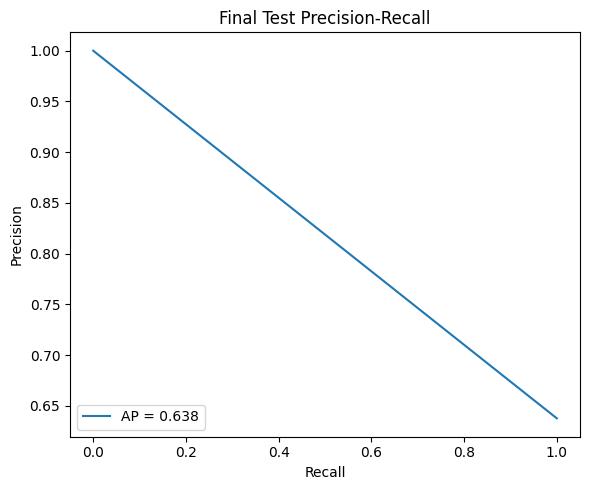

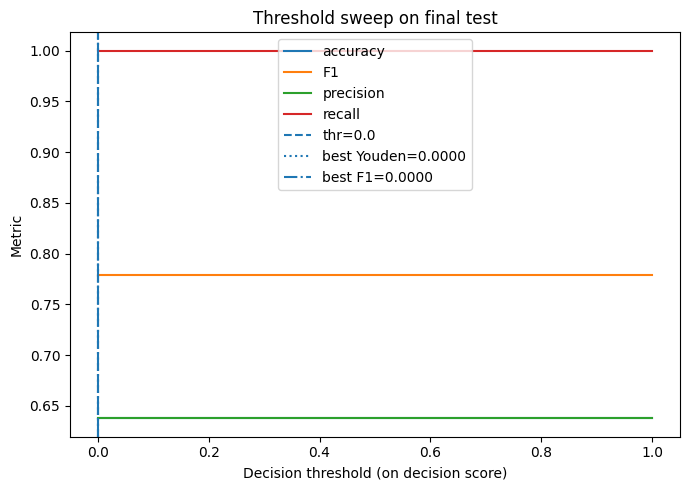

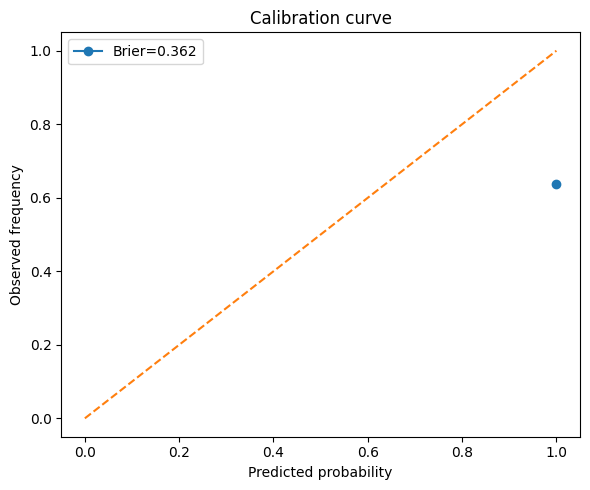

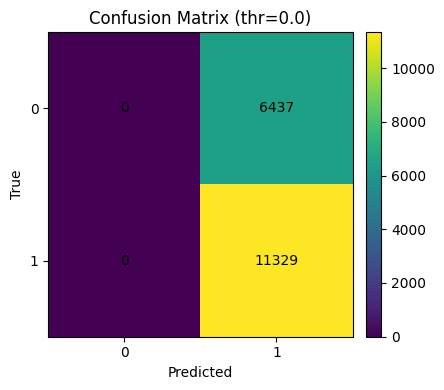

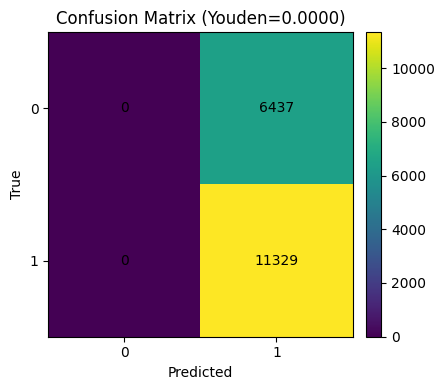

Report @ thr=0.0
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      6437
           1      0.638     1.000     0.779     11329

    accuracy                          0.638     17766
   macro avg      0.319     0.500     0.389     17766
weighted avg      0.407     0.638     0.497     17766


Report @ best Youden
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      6437
           1      0.638     1.000     0.779     11329

    accuracy                          0.638     17766
   macro avg      0.319     0.500     0.389     17766
weighted avg      0.407     0.638     0.497     17766



/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

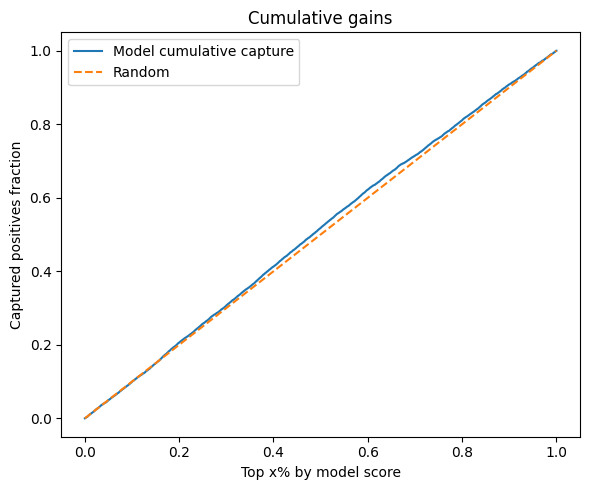

No per-ticker info; skipping.


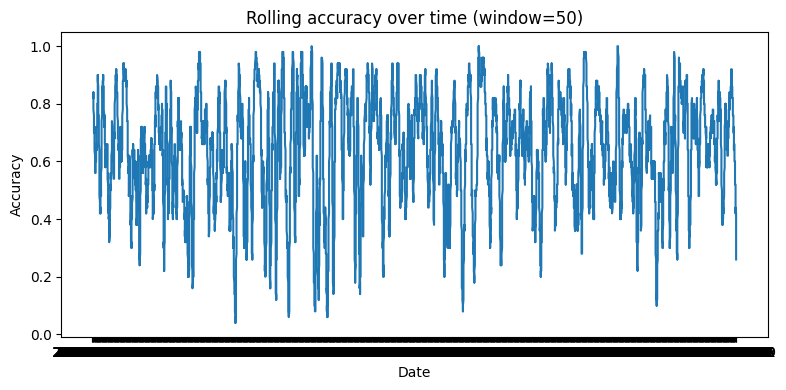

In [12]:
from src.visualization.eval_plots import run_full_eval_and_plots
from sklearn.pipeline import Pipeline



df_eval, stats, sweep = run_full_eval_and_plots(
    dummy_clf,
    X_test,
    y_true,
    out_dir=conf.data_dir / "model_metrics" / 'dummy',
    proba_strategy="auto",   # "model" for real probs, "sigmoid" to force margin->prob, "none" to skip probs
)